# Use case San Francisco bay
# Downloading and processing LiDAR data and aerial photograph
Gerben Hagenaars

This notebook uses the tutorials (given in previous notebooks) on the San Francisco bay pointcloud. It treats getting LiDAR data for San Francisco bay, and give it a color using aerial photographs.

In [2]:
# Import packages
import logging
import json
import os
import urlparse

logging.root.setLevel(logging.DEBUG)

# computing
import numpy as np

#plotting
import matplotlib.pyplot as plt
%matplotlib inline

# for spatial types
import owslib.wfs
import owslib.wms
# for spatial operations
import shapely.geometry
from matplotlib import collections

# for pointclouds
import liblas
from liblas import file

# numpy compatible, uncompressed only for now
import laspy.file
# for downloading
import requests
#  for xml parsing
import lxml.etree
import mako

# for aerial photo saturation
import skimage as ski
import gdal
import datetime 
import subprocess
os.environ["LD_LIBRARY_PATH"] = "/usr/local/lib"

## LiDAR

The lidar data can be downloaded from the <a href="http://earthexplorer.usgs.gov/">USGS Earth explorer</a> dataset with the <a href="http://earthexplorer.usgs.gov/bulk/ ">bulk order downloader</a>. A polygon is defined for the bay of San Francisco. ![image](printscreen_SF.png) All LiDAR files with a footprint inside this polygon can be ordered and downloaded at once. The files are small and have a size of approx. 150 MB. The files are downloaded as compressed las files. 

To process the LiDAR data of the San Francisco bay the .zip and .laz files will have to be unpacked to .las files. After that the Aerial photos will be processed and merged with the .las files. Finally the colored las files will be merged to one single file that can be converted into WebGL with PotreeConverter.

First, unpack the .zip files and .laz files wis las2las and store the .las files in a seperate folder.

In [2]:
folder_laz = 'LIDAR_laz/'
folder_las = 'LIDAR_las/'
folder_color = 'LIDAR_las_color/'

# unpack all zip files of las
for zip_file in os.listdir(folder_laz):
    if '.ZIP' in zip_file:
        zipfile = folder_laz + zip_file
        !unzip -o $zipfile
        for path, subdirs, files in os.walk(zip_file.replace('ZIP', '')):
            for name in files:
                if '.las' in name and '.xml' not in name:
                    os.rename(path + '/' + name, folder_laz + name)  # move tif to folder

        os.remove(zipfile)  # remove .zip

In [19]:
#unpack laz to las and put in correct folder
for files in os.listdir(folder_laz):
    filename = folder_laz + files  # laz 
    new_f = files.replace("-", "_")  # otherwise goes wrong in shell
    new_f = folder_las + new_f.replace('.laz', '.las')
    new_f_color = new_f.replace(folder_las, folder_color)
    new_f_color = new_f_color.replace('.las', '_color.las')
    if not os.path.exists(new_f) and '.las' in new_f:
        !las2las --input $filename --output $new_f
        
#get Las information    
print new_f
!lasinfo --no-check -i $new_f

LIDAR_las/ARRA_CA_GoldenGate_2010_001077.las
---------------------------------------------------------
  Header Summary
---------------------------------------------------------

  Version:                     1.2
  Source ID:                   0
  Reserved:                    1
  Project ID/GUID:             '00000000-0000-0000-0000-000000000000'
  System ID:                   'Golden Gate LiDAR Project 2010'
  Generating Software:         'LeicaALS60200KHz'
  File Creation Day/Year:      213/11
  Header Byte Size             227
  Data Offset:                 421
  Header Padding:              100
  Number Var. Length Records:  1
  Point Data Format:           1
  Number of Point Records:     4838318
  Compressed:                  False
  Number of Points by Return:  4610189 196462 27960 3707 0 
  Scale Factor X Y Z:          0.00100000000000 0.00100000000000 0.00100000000000
  Offset X Y Z:                543500.000 4152000.000 -0.000
  Min X Y Z:                   554500.000 418550

The las files contain the x, y and z coordinates of the point cloud.

## Aerial photo 

The Aerial photo's can also be downloaded from the USGS Earth Explorer. The files are compressed as .zip folders, and contain amongst others the .geotiff photo's. Let unpack the files and store only the photo's in a seperate folder. 

In [7]:
#unpack all tif files and put in correct folder
folder = 'AERIAL_photos/'

for zip_file in os.listdir(folder):
    if '.zip' in zip_file:
        zipfile = folder + zip_file
        !unzip -o $zipfile
        
        for path, subdirs, files in os.walk('CA'):
            for name in files:
                if '.tif' in name and '.xml' not in name:
                    if '10seg' in name or 'sfo' in name:  # filter only SF project and recent photo's
                        print path, name
                        os.rename(path + '/' + name, folder + name)  # move tif to folder
        
        os.remove(zipfile)  # remove .zip            

Let's check what area the photo's cover and what area is covered by the las files.

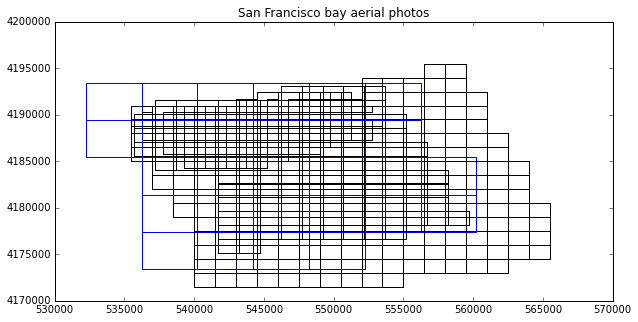

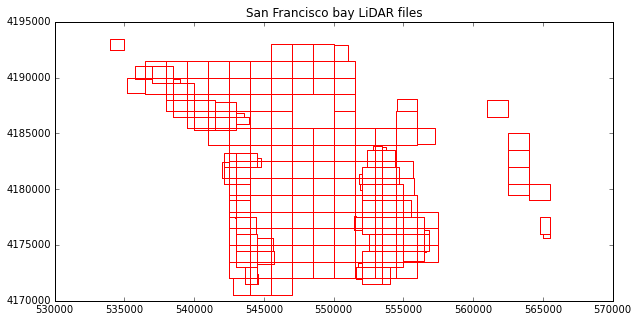

In [5]:
folder = 'AERIAL_photos/'
folder_las = 'LIDAR_las/'
fig = plt.figure()
fig.set_size_inches(10, 5)
plt.title('San Francisco bay aerial photos')  

#aerial photos
for photo_name in os.listdir(folder):
    
        #get bounding box of aerial photo's
        image_sat = folder + photo_name
        ds = gdal.Open(image_sat)
        width = ds.RasterXSize
        height = ds.RasterYSize

        gt = ds.GetGeoTransform()
        minx = gt[0]
        miny = gt[3] + width*gt[4] + height*gt[5]
        maxx = gt[0] + width*gt[1] + height*gt[2]
        maxy = gt[3]
        ds = None

        poly_image = shapely.geometry.Polygon(((minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)))
        x, y = poly_image.exterior.xy
        if 'seg' in photo_name: 
            plt.plot(x, y, 'black')
        if 'sfo' in photo_name: 
            plt.plot(x, y, 'blue')
            
fig = plt.figure()
fig.set_size_inches(10, 5)
plt.title('San Francisco bay LiDAR files') 

#LiDAR las files
for las_file in os.listdir(folder_las):
    f = file.File(folder_las + las_file, mode='r')
    max = f.header.get_max()
    min = f.header.get_min()
    x_max = max[0]
    x_min = min[0]
    y_max = max[1]
    y_min = min[1]
    z_max = max[2]
    z_min = min[2]
    f.close()
    poly_lidar = shapely.geometry.Polygon(((x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)))
    if 'ARRA' in las_file:
        x, y = poly_lidar.exterior.xy
        plt.plot(x, y, 'red')

The received pictures are approx. 100 MB. The pictures are a bit grey, and it's a good idea to increase the saturation. To increase saturation, the rgb values are converted to hsv so that the s column (saturation) can be increased. After that the hsv values are converted back to rgb. The large amount of data gives RAM memory issues. Therefore the picture is split into N parts to process only a part of the picture at a time and the RAM memory is cleaned after each step.
The saturated tiff file has lost it's georeference information. Therefore, the geo information will be used from the original (downloaded) geotiff and merged.

In [ ]:
#for all images in folder, increase saturation
from skimage import color
import matplotlib as matplotlib

folder = 'AERIAL_photos/'
for photo_name in os.listdir(folder):
    if '.tif' in photo_name:
        image = folder + photo_name
        image_sat = image.replace("_saturated", "")
        image_sat = image_sat.replace(".tif", "") + '_saturated.tif'
        
        if not os.path.exists(image_sat):
            print image,image_sat
            img = (plt.imread(image)).astype(np.uint8)

            #split image in N steps for processing (otherwise to much for virtual memory)
            img_new = None
            img_new = np.zeros_like(img).astype(np.float)  # new empty array to fill with saturated rgb

            pic_size = float(len(img))           # no. of pixels in 1 direction
            N = 5                                # no. of processing steps
            steps = pic_size / N                  # pixels per processing step

            for i in range(N):
                lower = i * int(steps)
                upper = (i + 1) * int(steps)

                img_process = img[lower:upper, :, :]
                hsv = ski.color.rgb2hsv(img_process)
                hsv[:, :, 1] *= 1.3  # increase saturation with 30%
                img_new[lower:upper, :, :] = ski.color.hsv2rgb(hsv)

                img_process = None  # clear memory for next step
                hsv = None

            plt.imsave(image_sat, arr=img_new, format='tiff')  # save picture as tiff (spatial information lost)
            
            img_new = None
            img = None
            
            #spatial information is lost in saturated tiff. Copy spatial info from original tiff           
            ds_input = gdal.Open(image)  # get geo information from tiff file with spatial information
            projection = ds_input.GetProjection()
            geotransform = ds_input.GetGeoTransform()
            gcp_count = ds_input.GetGCPs()

            ds_output = gdal.Open(image_sat, gdal.GA_Update)  # saturated tiff file without spatial information
            ds_output.SetProjection(projection)  # copy spatial info
            ds_output.SetGeoTransform(geotransform)
            ds_output.SetGCPs(gcp_count, ds_input.GetGCPProjection())

            #close dataset
            ds_input = None
            ds_output = None

            #os.remove(image) #remove nonstaturated geotiff

#project sample picture
fig = plt.figure()
fig.set_size_inches(20, 10)

plt.subplot(1, 2, 1)
plt.title('Original photo')
img = (plt.imread(image)).astype(np.uint8) 
plt.imshow(img);

plt.subplot(1, 2, 2)
plt.title('Saturated photo')
img = (plt.imread(image_sat)).astype(np.uint8) 
plt.imshow(img);

## Merge aerial photo and las file
Two aerial photo projectes weree downloaded from the buld order downaloded. The 'SEG' images are small, recent but are taken at other time instances so this will give a patchwork like result. The 'SFO' photos cover a large area but give RAM issues when they are processed.

The following steps are performed. First, check for each photo if it overlaps with the bounding box of the las file. All the aerial photos that fit one las file are then merged to 1 single image. This image is merged with the las file. Because the merged aerial photo may also be used for other las files this image is put back in the folder to be able to process it in the next step. Because of this procedure the 'SFO' photos are not suitable based on their output image that may be more then 8 GB (and gives RAM issues).

In [40]:
#check for each las file if it overlaps with aerial photo
folder_laz = 'LIDAR_laz/'
folder_las = 'LIDAR_las/'
folder_color = 'LIDAR_las_color/'
folder = 'AERIAL_photos/'

counter = 0
merge = False

print folder_las, folder
for las_file in os.listdir(folder_las):
    # Print header for bounding box
    f = file.File(folder_las + las_file, mode='r')
    max = f.header.get_max()
    min = f.header.get_min()
    x_max = max[0]
    x_min = min[0]
    y_max = max[1]
    y_min = min[1]
    z_max = max[2]
    z_min = min[2]
    f.close()
    
    #merge aerial photo and las file
    las_box = '"' + str(int(x_min)) + ' ' + str(int(y_min)) + ' ' + str(int(z_min)) + ' ' + str(int(x_max)) + ' ' + str(int(y_max)) + ' ' + str(int(z_max)) + '"'
    las_file_uncolored = folder_las + las_file
    las_file_colored = folder_color + las_file.replace(".las", "") + "_color.las"

    # Generate polygon from LiDAR file
    poly_lidar = shapely.geometry.Polygon(((x_min, y_min),(x_min, y_max),(x_max, y_max),(x_max, y_min),(x_min, y_min)))
    
    if 'ARRA_CA_GoldenGate_2010_000918.las' in las_file and not os.path.exists(las_file_colored):
        print las_file_colored
        overlapping_images = ''
        for photo_name in os.listdir(folder):
            #get bounding box of aerial photo's
            if 'seg' in photo_name or 'merged' in photo_name:
                image_sat = folder + photo_name
                ds = gdal.Open(image_sat)
                width = ds.RasterXSize
                height = ds.RasterYSize

                gt = ds.GetGeoTransform()
                minx = gt[0]
                miny = gt[3] + width * gt[4] + height * gt[5]
                maxx = gt[0] + width * gt[1] + height * gt[2]
                maxy = gt[3]
                ds = None
                poly_image = shapely.geometry.Polygon(((minx, miny),(minx, maxy),(maxx, maxy),(maxx, miny),(minx, miny)))
                
                #check if polygon image intersects with polygon of pointcloud
                if poly_image.contains(poly_lidar):  # if completely overlaps, no need to merge pictures
                    overlapping_images = image_sat
                    merge = False
                    break

                if poly_lidar.intersects(poly_image) and 'merged' not in image_sat:  # if it intersect merge with gdalwarp
                    overlapping_images = overlapping_images + ' ' + image_sat
                    merge = True

        print overlapping_images, merge
        now = datetime.datetime.now()
        now = str(now.hour) + str(now.minute) + str(now.second) + str(now.microsecond)
        if merge: #  merge aerial photos
            merged_tif = folder + 'merged_' + now + '.tif'
            !gdalwarp $overlapping_images $merged_tif
        else: 
            merged_tif = overlapping_images

        !las2las --color-source $merged_tif --point-format 3 --color-source-bands 1 2 3 --color-source-scale 256 --extent $las_box -i $las_file_uncolored -o $las_file_colored
        counter += 1

LIDAR_las/ AERIAL_photos/
LIDAR_las_color/ARRA_CA_GoldenGate_2010_000918_color.las
 AERIAL_photos/10seg4620182612.tif AERIAL_photos/10seg4770284112.tif AERIAL_photos/10seg460835.tif AERIAL_photos/10seg475835.tif AERIAL_photos/10seg4770282612.tif AERIAL_photos/10seg4620184112.tif AERIAL_photos/10seg475850.tif True
Creating output file that is 10678P x 12960L.
Processing input file AERIAL_photos/10seg4620182612.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Processing input file AERIAL_photos/10seg4770284112.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Processing input file AERIAL_photos/10seg460835.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Processing input file AERIAL_photos/10seg475835.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Processing input file AERIAL_photos/10seg4770282612.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Processing input file AERIAL_photos/10seg4620184112.tif.


There is 1 box that is outside the domain covered by the 'SEG' project aerial photos. Let's merge this one with an aerial photo from the 'SFO' project.

In [9]:
#box that's outside the aerial photo domain, do it manually
merged_tif = 'sfo_13c12.tif'
las_file_colored = 'ARRA_CA_SanFranCoast_2010_000011_color.las'
las_file_uncolored = 'ARRA_CA_SanFranCoast_2010_000011.las'
!las2las --color-source $merged_tif --point-format 3 --color-source-bands 1 2 3 --color-source-scale 256 -i $las_file_uncolored -o $las_file_colored

For the PotreeConverter it is better to work with 1 .las file. Let's combine all the colored lasfiles to 1 single file.

In [19]:
#merge all las files to 1 las file
input_files = folder_color + '*.las'
output_file = 'SF_LiDAR_2.las'  # output file
print input_files, output_file

LIDAR_las_color/*.las SF_LiDAR_2.las


In [20]:
%%bash -s "$input_files" "$output_file"
lasmerge -i $1 -o $2

ERROR: 'end-of-file' after 1037505 of 6876047 points


In [23]:
# drop all water (classified as 9) and noise points (classified as 7) points
input_files = output_file
output = 'SF_LiDAR_3.las'
print input_files, output
!las2las --point-format 3 --color-source-bands 1 2 3 --drop-classes 7 9 --color-source-scale 256 -i $input_files -o $output
#todo this doesn't work because Liblas has to be compiled from source in ubuntu 14

SF_LiDAR_2.las SF_LiDAR_3.las
Segmentation fault (core dumped)


# PotreeConverter
Use PotreeConverter to convert .laz to Octree WebGL (this might take some time).
To automatically generate a webpage viewer with the correct variables automatically set, make sure resources/page_template is in working dir.

In [24]:
potree_output = 'Potree_converted_SF_2'  # folder for potree output
print output_file, potree_output

SF_LiDAR_2.las Potree_converted_SF_2


In [25]:
%%bash -s "$output_file" "$potree_output"
PotreeConverter $1 -l 9 --generate-page -o $2

== params ==
source[0]:         	SF_LiDAR_2.las
outdir:            	Potree_converted_SF_2
spacing:           	0
diagonal-fraction: 	250
levels:            	9
format:            	
scale:             	0
output-format:     	BINARY

spacing calculated from diagonal: 156.137
Last level will have spacing:     0.609909

AABB: 
min: [534,000, 4.1705e+06, -155.41]
max: [565,500, 4.1935e+06, 1,398.89]
size: [31,500, 23,000, 1,554.3]

cubic AABB: 
min: [534,000, 4.1705e+06, -155.41]
max: [565,500, 4.202e+06, 31,344.6]
size: [31,500, 31,500, 31,500]

reading SF_LiDAR_2.las
INDEXING: 5,000,000 points processed; 4,709,099 points written; 31.413 seconds passed
INDEXING: 10,000,000 points processed; 8,886,934 points written; 64.04 seconds passed
INDEXING: 15,000,000 points processed; 12,717,671 points written; 100.952 seconds passed
INDEXING: 20,000,000 points processed; 16,877,605 points written; 137.637 seconds passed
INDEXING: 25,000,000 points processed; 21,347,841 points written; 177.444 seconds 